
# CC3045 – Deep Learning y Sistemas Inteligentes  
## Laboratorio 8 — **Task 1 (Kaggle-ready)**: LSTM para *Store Item Demand Forecasting*

Autoras: Michelle Mejia y Silvia Illescas

Este notebook incluye preparación de datos, ventanas, LSTM, entrenamiento, evaluación y **creación de `submission.csv` alineado con `test.csv` (id,date,store,item)** para la competencia:
**`demand-forecasting-kernels-only`**.


## 1) Imports y configuración

In [1]:

!pip install pandas numpy matplotlib scikit-learn


import os, math, json, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(42)
tf.random.set_seed(42)

DATA_DIR = './data'
TRAIN_PATH = os.path.join(DATA_DIR, 'train.csv')
TEST_PATH  = os.path.join(DATA_DIR, 'test.csv')
SAMPLE_SUB_PATH = os.path.join(DATA_DIR, 'sample_submission.csv')

assert os.path.exists(TRAIN_PATH), f'No se encontró {TRAIN_PATH}'
assert os.path.exists(TEST_PATH),  f'No se encontró {TEST_PATH}'
print('TensorFlow:', tf.__version__)


TensorFlow: 2.19.0


## 2) Cargar datos y *overview*

In [2]:

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

# conversion de fechas
train['date'] = pd.to_datetime(train['date'])
test['date']  = pd.to_datetime(test['date'])

train = train.sort_values(['store','item','date']).reset_index(drop=True)
test  = test.sort_values(['store','item','date']).reset_index(drop=True)

print('Train head:'); display(train.head())
print('Test head:'); display(test.head())

print('\nRango de fechas:')
print('Train:', train['date'].min(), '→', train['date'].max())
print('Test :', test['date'].min(), '→', test['date'].max())

print('\nSeries únicas (store,item):', train[['store','item']].drop_duplicates().shape[0])
print('Series en test (store,item):', test[['store','item']].drop_duplicates().shape[0])


Train head:


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Test head:


,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1



Rango de fechas:
Train: 2013-01-01 00:00:00 → 2017-12-31 00:00:00
Test : 2018-01-01 00:00:00 → 2018-03-31 00:00:00

Series únicas (store,item): 500
Series en test (store,item): 500



## 3) Limpieza y *feature engineering*
- Relleno de nulos en `sales` (si hubiera)
- Recorte de *outliers* por percentil alto
- Rasgos de calendario
- Objetivo en `log1p`


In [3]:

df = train.copy()
df['sales'] = df['sales'].fillna(0)
cap = df['sales'].quantile(0.999)
df['sales'] = np.clip(df['sales'], 0, cap)

def add_time_features(d):
    d['dow']   = d['date'].dt.dayofweek.astype('int16')
    d['week']  = d['date'].dt.isocalendar().week.astype('int16')
    d['month'] = d['date'].dt.month.astype('int16')
    d['year']  = d['date'].dt.year.astype('int16')
    d['day']   = d['date'].dt.day.astype('int16')
    return d

df  = add_time_features(df)
test_feat = add_time_features(test.copy())

df['sales_log1p'] = np.log1p(df['sales'])



## 4) Ventanas (WINDOW) y horizonte (HORIZON = 90 días)
Se entrena **un único modelo** para todas las series.


In [4]:

WINDOW  = 30
HORIZON = 90
TARGET  = 'sales_log1p'

feature_cols = ['dow','week','month','year','day','store','item']
cont_cols    = ['dow','week','month','year','day']
scaler = StandardScaler()

def build_sequences(group_df):
    X_seq, y_seq = [], []
    g = group_df.sort_values('date').copy()
    feat = g[feature_cols].copy()
    feat[cont_cols] = scaler.fit_transform(feat[cont_cols])
    y = g[TARGET].values

    for i in range(len(g) - WINDOW - HORIZON + 1):
        X_seq.append(feat.iloc[i:i+WINDOW].values)
        y_seq.append(y[i+WINDOW:i+WINDOW+HORIZON])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

X_list, y_list = [], []
for (s,it), g in df.groupby(['store','item'], sort=False):
    Xg, yg = build_sequences(g)
    if len(Xg):
        X_list.append(Xg); y_list.append(yg)

X = np.vstack(X_list)
y = np.vstack(y_list)

print('X:', X.shape, 'y:', y.shape)


X: (853500, 30, 7) y: (853500, 90)


## 5) Split temporal: train/val/test (por índice de ventanas)

In [5]:

n = len(X)
test_frac = 0.15
val_frac  = 0.15
n_test = int(n * test_frac)
n_val  = int(n * val_frac)
n_train = n - n_val - n_test

X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:], y[n_train+n_val:]
tuple(arr.shape for arr in [X_train, y_train, X_val, y_val, X_test, y_test])


((597450, 30, 7),
 (597450, 90),
 (128025, 30, 7),
 (128025, 90),
 (128025, 30, 7),
 (128025, 90))

## 6) Modelo LSTM

In [6]:

n_features = X.shape[2]
model = keras.Sequential([
    layers.Input(shape=(WINDOW, n_features)),
    layers.LSTM(64),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(HORIZON)
])
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse', metrics=[keras.metrics.MeanAbsoluteError(name='mae')])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90)             │        11,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,874 (151.85 KB)

 Trainable params: 38,618 (150.85 KB)

 Non-trainable params: 256 (1.00 KB)

## 7) Entrenamiento

In [7]:

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-5)
]
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    verbose=1,
    callbacks=callbacks
)
pd.DataFrame(history.history).tail()


Epoch 1/50
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 172s 72ms/step - loss: 2.6752 - mae: 1.0605 - val_loss: 0.5478 - val_mae: 0.6563 - learning_rate: 0.0010
Epoch 2/50
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 160s 68ms/step - loss: 0.2163 - mae: 0.3723 - val_loss: 0.5966 - val_mae: 0.6983 - learning_rate: 0.0010
Epoch 3/50
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 151s 65ms/step - loss: 0.1857 - mae: 0.3407 - val_loss: 0.5042 - val_mae: 0.6430 - learning_rate: 0.0010
Epoch 4/50
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 151s 65ms/step - loss: 0.1578 - mae: 0.3099 - val_loss: 0.4244 - val_mae: 0.6102 - learning_rate: 0.0010
Epoch 5/50
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 181s 78ms/step - loss: 0.1004 - mae: 0.2453 - val_loss: 0.3964 - val_mae: 0.5892 - learning_rate: 0.0010
Epoch 6/50
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 183s 79ms/step - loss: 0.0908 - mae: 0.2318 - val_loss: 0.3878 - val_mae: 0.5773 - learning_rate: 0.0010
Epoch 7/50
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 183s 78ms/step - loss: 0.0929 - mae: 0.2342 - val_loss: 0.3519 - val_mae: 0.

,loss,mae,val_loss,val_mae,learning_rate
11,0.047795,0.170328,0.328290,0.544183,0.0010
12,0.046244,0.167384,0.341258,0.555089,0.0010
13,0.043749,0.162869,0.401881,0.562550,0.0010
14,0.042074,0.159675,0.301380,0.521848,0.0005
15,0.041187,0.158014,0.303287,0.523804,0.0005


## 8) Evaluación interna (RMSE/MAE)

In [8]:

def inv_log1p(x): return np.expm1(x)

y_pred = model.predict(X_test, verbose=0)
mae = mean_absolute_error(inv_log1p(y_test).ravel(), inv_log1p(y_pred).ravel())
mse = mean_squared_error(inv_log1p(y_test).ravel(), inv_log1p(y_pred).ravel())
rmse = math.sqrt(mse)
print(f"MAE:  {mae:,.3f}\nRMSE: {rmse:,.3f}")


MAE:  23.645
RMSE: 28.780



## 9) **Forecast para `test.csv` y creación de `submission.csv`**
- Para cada `(store,item)` en `test`, se toma la **última ventana** de 30 días inmediatamente anterior al primer día de `test` (esto coincide con que `train` llega hasta 2017-12-31 y `test` arranca 2018-01-01).
- Se generan **90 días** de pronóstico (HORIZON) y luego se **empareja por (date,store,item)** con el `test`.
- Finalmente, se respeta el **orden original de `test.id`**.


In [9]:

# 1) Preparar última ventana por (store,item) usando train
def last_window_for_group(g):
    g = g.sort_values('date').copy()
    feat = g[feature_cols].copy()
    feat[cont_cols] = scaler.fit_transform(feat[cont_cols])
    if len(feat) < WINDOW:
        return None
    return feat.iloc[-WINDOW:].values.astype(np.float32)

# Fecha de inicio de test (por serie); el test puede tener 90 días seguidos por serie
first_test_date = test['date'].min()

# 2) Generar pronóstico horizonte=90 para cada (store,item) que aparece en test
pred_rows = []
for (s,it), gtest in test.groupby(['store','item'], sort=False):
    gtrain = df[(df['store']==s) & (df['item']==it)]
    X_last = last_window_for_group(gtrain)
    if X_last is None:
        # Si faltan datos, saltar o predecir con constante (fallback)
        continue
    pred_log = model.predict(X_last[None, :, :], verbose=0)[0]
    pred = np.expm1(pred_log)
    start_date = gtrain['date'].max() + pd.Timedelta(days=1)
    dates = pd.date_range(start=start_date, periods=HORIZON, freq='D')
    tmp = pd.DataFrame({'date': dates, 'store': s, 'item': it, 'sales': pred})
    pred_rows.append(tmp)

forecast_all = pd.concat(pred_rows, ignore_index=True)
# 3) Empatar con test exacto por (date, store, item)
merged = test.merge(forecast_all, on=['date','store','item'], how='left')

# 4) Post-proceso: ventas no negativas y redondeo opcional (normalmente no se requiere)
merged['sales'] = merged['sales'].clip(lower=0)

# 5) Ordenar por id y exportar
submission = merged[['id','sales']].sort_values('id').reset_index(drop=True)
os.makedirs('./outputs', exist_ok=True)
sub_path = './outputs/submission.csv'
submission.to_csv(sub_path, index=False)
print('Guardado:', sub_path)
display(submission.head())


Guardado: ./outputs/submission.csv


,id,sales
0,0,13.982466
1,1,16.129742
2,2,16.138718
3,3,17.213034
4,4,18.698057



## 10) Visualización rápida para una serie (opcional)


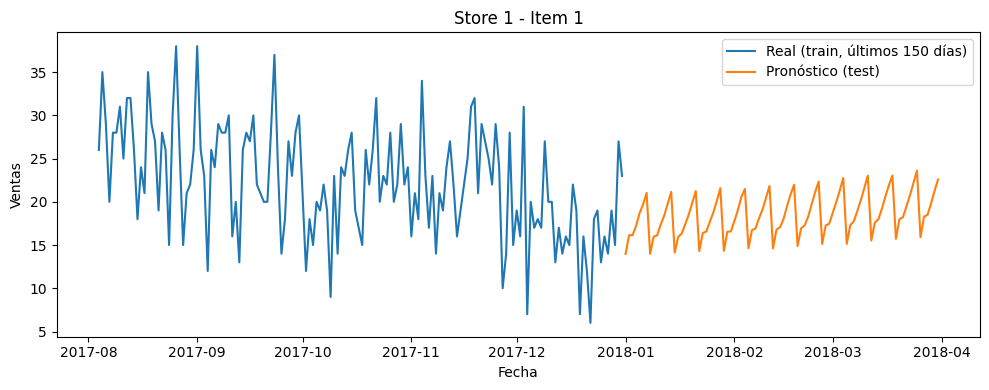

In [10]:

example = test[['store','item']].drop_duplicates().iloc[0].tolist()
ex_store, ex_item = example
gtrain = train[(train['store']==ex_store) & (train['item']==ex_item)].sort_values('date')
gtest  = test[(test['store']==ex_store) & (test['item']==ex_item)].sort_values('date')
gpred  = submission.merge(test, on='id').query('store==@ex_store and item==@ex_item')

plt.figure(figsize=(10,4))
plt.plot(gtrain['date'].tail(150), gtrain['sales'].tail(150), label='Real (train, últimos 150 días)')
plt.plot(gtest['date'], gpred['sales'], label='Pronóstico (test)')
plt.title(f'Store {ex_store} - Item {ex_item}')
plt.xlabel('Fecha'); plt.ylabel('Ventas')
plt.legend(); plt.tight_layout(); plt.show()



## 11) Guardar artefactos
- `./outputs/submission.csv` con columnas **id,sales** para subir a Kaggle
- `./models/lstm_forecast_90d.keras` para reutilizar el modelo
- `./models/metadata.json` con parámetros clave


In [11]:

os.makedirs('./models', exist_ok=True)
model.save('./models/lstm_forecast_90d.keras')
meta = {
    'window': int(WINDOW),
    'horizon': int(HORIZON),
    'feature_cols': feature_cols,
    'cont_cols': cont_cols,
    'target': TARGET
}
with open('./models/metadata.json', 'w') as f:
    json.dump(meta, f, indent=2)
print('Modelo y metadatos guardados en ./models')


Modelo y metadatos guardados en ./models
